In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
#import h5py
import sys
import os
import pyflct
from scipy.stats import pearsonr
from tqdm import tqdm
import time
# We need this to navigate through our data
import muram as muram

# Input/output
from astropy.io import fits

In [4]:
# fromfile loading
first = np.fromfile("tau_slice_0.100.000000", dtype = "float32")
first_ = first[4:].reshape(11, 1536, 1536)
Bz_1 = first_[7,:,:]
Bz_1 = Bz_1 * np.sqrt(4*np.pi)

In [5]:
# read_slice loading
path = ''
data1 = muram.read_slice(path, 0, 'tau', '0.100' )
test1 = np.copy(data1[0][5,:,:] * np.sqrt(4 * np.pi))

Text(0.5, 1.0, 'read_slice reading')

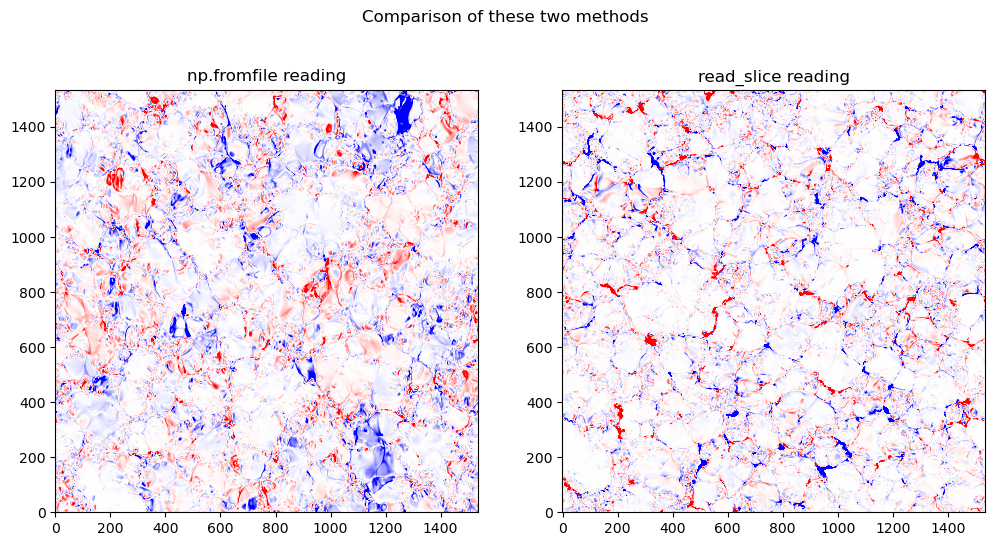

In [8]:
# Comparison of these two methods
fig = plt.figure(figsize = (12,6))
fig.suptitle("Comparison of these two methods")
ax1 = fig.add_subplot(121)
ax1.imshow(Bz_1[:,:], origin='lower',cmap='bwr', vmin = -200, vmax = 200)
ax1.set_title("np.fromfile reading") 

ax2 = fig.add_subplot(122)
ax2.imshow(test1[:,:], origin='lower', cmap='bwr', vmin = -200, vmax = 200)
ax2.set_title("read_slice reading") 

In [2]:
filenames = []

# Retreiving only numerical files
for file in sorted(os.listdir (os.getcwd())):
	if file.startswith("tau_slice_0.100"):
		#print (file)
		filenames.append(file)

In [3]:
bz = []
vxr = []
vyr = []

In [4]:
test_range = 4
for iter in range(test_range):
    test = filenames[iter]
    print(test)
    data_full = np.fromfile(test, dtype="float32")
    data = data_full[4:].reshape(11, 1536, 1536)
    Bz = data[7,:,:]
    Vx = data[1,:,:]
    Vy = data[2,:,:]
    vxr.append(Vx)
    vyr.append(Vy)
    bz.append(Bz)

tau_slice_0.100.000000
tau_slice_0.100.000050
tau_slice_0.100.000100
tau_slice_0.100.000150


In [5]:
print(bz)

[array([[-1.2307711e-01, -6.1460692e-02,  9.7903007e-01, ...,
         1.5572692e+01, -5.9001675e+00, -2.4108095e+00],
       [ 1.4817357e+00,  1.1856296e+00,  1.4907622e+00, ...,
         4.3594765e+01,  8.7437028e-01, -1.9654992e+00],
       [ 4.1264677e+00,  4.5370173e+00,  2.8614097e+00, ...,
         6.4753395e+01,  1.8671873e+01, -5.7184333e-01],
       ...,
       [-1.7290819e+00,  1.0581242e+00,  4.7954869e+00, ...,
        -1.0203753e+01, -5.8869681e+00, -3.5273857e+00],
       [-2.2132192e+00, -8.5384148e-01,  2.3429048e+00, ...,
        -8.9488935e+00, -6.1397605e+00, -3.0906522e+00],
       [-2.4152336e+00, -1.1099466e+00,  8.1951374e-01, ...,
        -7.4231040e-01, -6.0170689e+00, -2.8802278e+00]], dtype=float32), array([[-0.90205973, -0.33192447,  0.28235278, ..., 50.022545  ,
         2.6317778 , -4.5267444 ],
       [ 0.31254798,  1.52517   ,  1.869989  , ..., 75.27784   ,
        23.950302  , -2.1018913 ],
       [ 2.548713  ,  5.4114146 ,  4.4455156 , ..., 80.0945   

In [20]:
bz = np.asarray(bz)
bz = bz*np.sqrt(4*np.pi)
vxr = np.asarray(vxr)
vyr = np.asarray(vyr)

In [26]:
bz = []

first = np.fromfile("tau_slice_0.100.000000", dtype = "float32")
first_ = first[4:].reshape(11, 1536, 1536)
Bz_1 = first_[7,:,:]
bz.append(Bz_1)

second = np.fromfile("tau_slice_0.100.000150", dtype = "float32")
second_ = second[4:].reshape(11, 1536, 1536)
Bz_2 = second_[7,:,:]
bz.append(Bz_2)

In [27]:
print("Bz shape:", np.shape(bz))
# Now we can define cadence, FWHM, pixelsize and sigma that FLCT will use 

deltat = 30 # in seconds
fwhm = 100 # in kilometres
pixelsize = 16 # in kilometres
sigma = fwhm/1.665/pixelsize # size of the apodizing window
threshold = 0

Bz shape: (2, 1536, 1536)


In [28]:
vxb, vyb, vmb = pyflct.flct(bz[0], bz[1], deltat, pixelsize, sigma, thresh = 0)
vxb = np.asarray(vxb)
vyb = np.asarray(vyb)
vmb = np.asarray(vmb)
ts = time.time()

flct: nominal sliding box size = 12
flct: mean value of gamma^2/sigma^2 = 0.326077 = 864 out of 1535

flct: finished


In [29]:
# Create the fits file to store these velocities
# with appropriate header
cube = np.concatenate((vxb[None,:,:], vyb[None,:,:]), axis = 0)
print(np.shape(cube))
out0 = fits.PrimaryHDU(cube[0])

# Header information 
out0.header['UNITS'] = 'km/s' # units that velocities are in 
out0.header['TRACKED'] = 'Bz' # the parameter which was tracked
out0.header['WHEN_RUN'] = ts # timestamp of run
out0.header['AUTHOR'] = 'Teodor'
out0.header['FWHM'] = fwhm # in kilometres
out0.header['PIXELSIZE'] = pixelsize
out0.header['SIGMA'] = sigma # FLCT window in kilometres 
out0.header['DELTAT'] = deltat # time interval between two frames in seconds
out0.header['THRESHOLD'] = threshold # FLCT is not applied to pixels below this
out0.header['SIMSTEP'] = 0.2 # should match the filename
out0.header['SIMTIME'] = 3600 # 1 hour
out0.header['COMMENT'] = ''

out1 = fits.ImageHDU(cube[1])
#out2 = fits.ImageHDU(cube[2])
out = fits.HDUList([out0, out1])



out.writeto("pyFLCT_fwhm" + str(fwhm) + "_dt" + str(deltat) + "_Bz_" + filenames[0] + "_example.fits", overwrite=True)

(2, 1536, 1536)


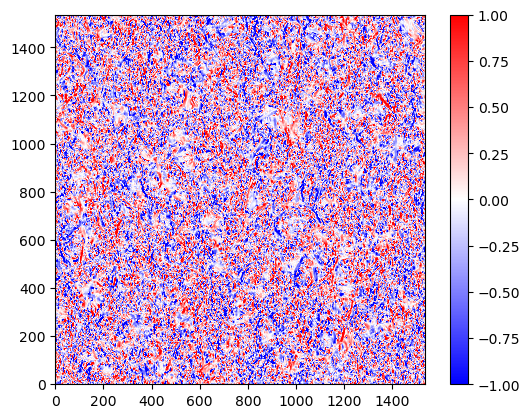

In [30]:
novo_v = fits.open("pyFLCT_fwhm100_dt30_Bz_tau_slice_0.100.000000_example.fits")[0].data
plt.imshow(novo_v, origin = "lower", cmap = "bwr", vmin = -1, vmax = 1)
plt.colorbar()

Text(0.5, 1.0, 'My code')

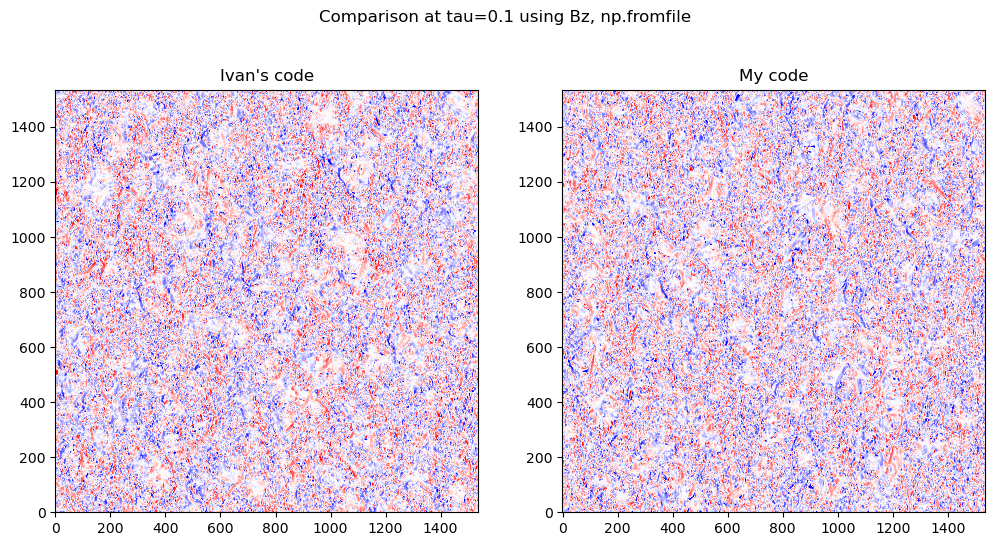

In [40]:
fcube_Ivan = fits.open("ivan_flct_Bz_30s_tau0.1_fwhm100_tracked.fits")[0].data
cube_Teodor = fits.open("pyFLCT_fwhm100_dt30_Bz_tau_slice_0.100.000000_example.fits")[0].data 
fig = plt.figure(figsize = (12,6))
fig.suptitle("Comparison at tau=0.1 using Bz, np.fromfile")
ax1 = fig.add_subplot(121)
ax1.imshow(fcube_Ivan[0,:,:], origin='lower',cmap='bwr', vmin = -2, vmax = 2)
ax1.set_title("Ivan's code") 

ax2 = fig.add_subplot(122)
ax2.imshow(cube_Teodor[:,:], origin='lower', cmap='bwr', vmin = -2, vmax = 2)
ax2.set_title("My code") 

In [36]:
# Opening files using read_slice function
path = ''
data1 = muram.read_slice(path, 0, 'tau', '0.100' )
test1 = np.copy(data1[0][5,:,:] * np.sqrt(4 * np.pi))

data2 = muram.read_slice(path, 150, 'tau', '0.100')
test2 = np.copy(data2[0][5,:,:] * np.sqrt(4 * np.pi))

In [37]:
vel_x, vel_y, vm = pyflct.flct(test1, test2, deltat, pixelsize, sigma)

flct: nominal sliding box size = 12
flct: mean value of gamma^2/sigma^2 = 0.307698f 1535

flct: finished


Text(0.5, 1.0, 'My code')

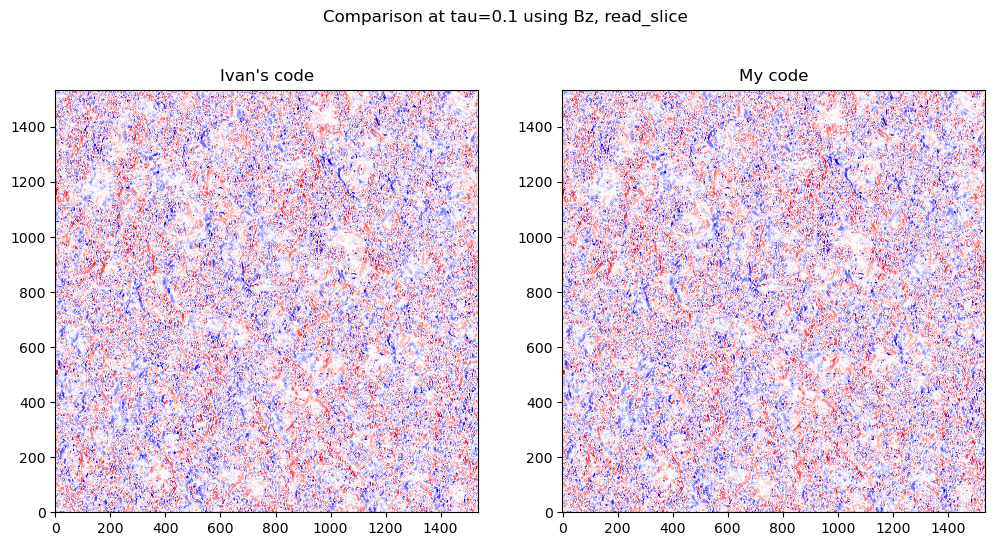

In [39]:
fcube_Ivan = fits.open("ivan_flct_Bz_30s_tau0.1_fwhm100_tracked.fits")[0].data
#cube_Teodor = fits.open("pyFLCT_fwhm100_dt30_Bz_tau_slice_0.100.000000_example.fits")[0].data 
fig = plt.figure(figsize = (12,6))
fig.suptitle("Comparison at tau=0.1 using Bz, read_slice")
ax1 = fig.add_subplot(121)
ax1.imshow(fcube_Ivan[0,:,:], origin='lower',cmap='bwr', vmin = -2, vmax = 2)
ax1.set_title("Ivan's code") 

ax2 = fig.add_subplot(122)
ax2.imshow(vel_x[:,:], origin='lower', cmap='bwr', vmin = -2, vmax = 2)
ax2.set_title("My code") 

In [ ]:
fig = plt.figure(figsize = (12,6))
fig.suptitle("Comparison at tau=0.1 using Bz, read_slice")
ax1 = fig.add_subplot(121)
ax1.imshow(Bz_1[0,:,:], origin='lower',cmap='bwr', vmin = -2, vmax = 2)
ax1.set_title("Ivan's code") 

ax2 = fig.add_subplot(122)
ax2.imshow(test1[:,:], origin='lower', cmap='bwr', vmin = -2, vmax = 2)
ax2.set_title("My code") 